# Installs

please restart session after installing numpy and run it again

In [ ]:
!pip install "numpy<2.0"
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

!pip install torch_geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 484.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling tor

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, GCNConv, GATConv, GINConv, LayerNorm, BatchNorm
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, global_sort_pool
from torch_geometric.data import DataLoader
from torch_geometric.nn.aggr import SumAggregation, MeanAggregation, MaxAggregation, StdAggregation

import numpy as np
import pandas as pd
import time
import psutil
import os
import pickle
from typing import Dict, List, Tuple, Any
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import warnings
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import ParameterSampler

warnings.filterwarnings('ignore')

# Bayesian Optimization imports
try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer, Categorical
    from skopt.utils import use_named_args
    from skopt.acquisition import gaussian_ei
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    print("Warning: scikit-optimize not available. Please install with: pip install scikit-optimize")
    BAYESIAN_OPT_AVAILABLE = False

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool, global_add_pool
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Configurations

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Loading the dataset

1. **Nodes**: Amino acids.
2. **Edges**: Connections between amino acids that are within 6 Ångströms of each other.
3. **Labels**: Binary classification indicating whether a protein is an enzyme or not.

Clarification:
1. The 89 features are node features, not graph-level features (Structural information, Chemical properties)


In [ ]:
print("Loading DD dataset...")
dataset = TUDataset(root='/tmp/DD', name='DD')

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Get first graph for exploration
data = dataset[0]
print(f"\nFirst graph:")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of edges: {data.edge_index.shape[1]}")
print(f"Node feature shape: {data.x.shape}")
print(f"Label: {data.y}")

Loading DD dataset...


Processing...


Dataset: DD(1178)
Number of graphs: 1178
Number of features: 89
Number of classes: 2

First graph:
Number of nodes: 327
Number of edges: 1798
Node feature shape: torch.Size([327, 89])
Label: tensor([0])


Done!


# DATA PREPROCESSING

In [ ]:
data_list = [data for data in dataset]

## splitting

In [ ]:
from sklearn.model_selection import train_test_split

labels = [data.y.item() for data in data_list]
all_indices = list(range(len(data_list)))

# First split: 60% train, 40% (val+test)
train_idx, temp_idx = train_test_split(
    all_indices,
    test_size=0.4,
    stratify=labels,
    random_state=42
)

# Second split: 20% val, 20% test from the remaining 40%
# So test_size=0.5 here means 50% of the 40% => 20% of the total
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


In [ ]:
print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")


Train set size: 706
Validation set size: 236
Test set size: 236


In [ ]:
train_dataset = [data_list[i] for i in train_idx]
val_dataset = [data_list[i] for i in val_idx]
test_dataset = [data_list[i] for i in test_idx]

# data loaders

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Batch size: 32
Number of training batches: 23
Number of validation batches: 8
Number of test batches: 8


# TRAINING UTILITIES

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    if torch.cuda.is_available():
        gpu_memory_mb = torch.cuda.memory_allocated() / 1024 / 1024
        return memory_mb, gpu_memory_mb
    return memory_mb, 0

def measure_inference_time(model, loader, device, num_samples=100):
    model.eval()
    times = []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i * batch.y.size(0) >= num_samples:
                break
            batch = batch.to(device)
            start_time = time.time()
            _ = model(batch.x, batch.edge_index, batch.batch)
            end_time = time.time()
            batch_time = (end_time - start_time) / batch.y.size(0)
            times.append(batch_time)
    return np.mean(times) * 1000  # Convert to milliseconds


# Model definition: GraphSAGE



1.   It is a GraphSAGE-based neural network used for graph classification.
2.   **SAGEConv** stands for "Sample and AggregatE Convolution"
3. How does SAGEConv work?
  1. Sampling a fixed number of neighbors for each node
  2. Aggregating information from these neighbors
  3. Combining the aggregated neighbor information with the node's own features


In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_layers,
                 aggregation='mean', dropout=0.3, global_pool='mean'):
        super().__init__()

        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(num_features, hidden_dim, aggr=aggregation))

        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr=aggregation))

        self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr=aggregation))

        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

        # Global pooling function
        self.global_pool = {
            'mean': global_mean_pool,
            'max': global_max_pool,
            'add': global_add_pool
        }[global_pool]

    def forward(self, x, edge_index, batch):
        for conv in self.convs[:-1]:
            # Apply all SageConv:
            x = F.relu(conv(x, edge_index))
            x = self.dropout(x)

        x = self.convs[-1](x, edge_index)
        x = self.global_pool(x, batch)
        return self.classifier(x)

# Training function

In [ ]:
def train_evaluate(model, train_loader, val_loader, test_loader, device, epochs=100, plot_training=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    patience_counter = 0
    start_time = time.time()

    # For plotting and peak memory tracking
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    epoch_times = []
    peak_train_cpu = peak_train_gpu = 0
    peak_inf_cpu = peak_inf_gpu = 0

    for epoch in range(epochs):
        epoch_start = time.time()

        # Train with peak memory tracking
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Track peak memory during training
        cpu_mem, gpu_mem = get_memory_usage()
        peak_train_cpu = max(peak_train_cpu, cpu_mem)
        peak_train_gpu = max(peak_train_gpu, gpu_mem)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        # Validate every 10 epochs
        if epoch % 10 == 0:
            val_acc = evaluate(model, val_loader, device)
            train_acc = evaluate(model, train_loader, device)
            val_loss = evaluate_loss(model, val_loader, device, criterion)

            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= 5:  # Early stopping
                break

    training_time = time.time() - start_time

    # Plot training curves for best model
    if plot_training:
        plt.figure(figsize=(15, 5))
        epochs_range = range(0, len(train_losses) * 10, 10)

        plt.subplot(1, 3, 1)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train vs Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, train_accs, 'b-', label='Train Accuracy')
        plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train vs Validation Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Peak memory during inference
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            _ = model(batch.x, batch.edge_index, batch.batch)
            cpu_mem, gpu_mem = get_memory_usage()
            peak_inf_cpu = max(peak_inf_cpu, cpu_mem)
            peak_inf_gpu = max(peak_inf_gpu, gpu_mem)

    metrics = evaluate_detailed(model, test_loader, device)
    inference_time = measure_inference_time(model, test_loader, device)

    metrics.update({
        'training_time': training_time,
        'avg_epoch_time': np.mean(epoch_times),
        'parameters': count_parameters(model),
        'peak_train_cpu_mb': peak_train_cpu,
        'peak_train_gpu_mb': peak_train_gpu,
        'peak_inf_cpu_mb': peak_inf_cpu,
        'peak_inf_gpu_mb': peak_inf_gpu,
        'inference_time_ms': inference_time
    })

    return metrics

# Helper function for validation loss


In [ ]:
def evaluate_loss(model, loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation of model

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
    return correct / total

def evaluate_detailed(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='binary'),
        'precision': precision_score(all_labels, all_preds, average='binary'),
        'recall': recall_score(all_labels, all_preds, average='binary'),
        'predictions': all_preds,
        'labels': all_labels
    }


# Optimize the model

In [ ]:
def run_graphsage_tuning(dataset, train_loader, val_loader, test_loader, device, n_trials=30):
    param_dist = {
        'hidden_dim': [64, 128, 256],
        'num_layers': [2, 3, 4],
        'aggregation': ['mean', 'max', 'add'],
        'dropout': [0.2, 0.3, 0.5],
        'global_pool': ['mean', 'max', 'add']
    }

    results = []
    best_f1 = 0
    best_params = None

    print(f"GraphSAGE Random Search ({n_trials} trials)")
    print("=" * 50)

    # Random search
    for i, params in enumerate(ParameterSampler(param_dist, n_iter=n_trials, random_state=42)):
        print(f"Trial {i+1}/{n_trials}: {params}")

        model = GraphSAGE(
            num_features=dataset.num_features,
            num_classes=dataset.num_classes,
            **params
        ).to(device)

        metrics = train_evaluate(model, train_loader, val_loader, test_loader, device)

        result = {**params, **metrics}
        results.append(result)

        print(f"  F1: {metrics['f1']:.4f}, Acc: {metrics['accuracy']:.4f}, "
              f"Params: {metrics['parameters']}, Time: {metrics['training_time']:.1f}s")

        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_params = params

    # Train best model with plotting
    print(f"\nTraining best model with plotting: {best_params}")
    best_model = GraphSAGE(
        num_features=dataset.num_features,
        num_classes=dataset.num_classes,
        **best_params
    ).to(device)

    best_metrics = train_evaluate(best_model, train_loader, val_loader, test_loader, device, plot_training=True)

    # Results analysis
    df = pd.DataFrame(results)
    df.to_csv('graphsage_results.csv', index=False)
    torch.save(best_model.state_dict(), 'best_graphsage_model.pth')

    # Print comprehensive comparison
    best_result = df.loc[df['f1'].idxmax()]
    print("\n" + "=" * 70)
    print("COMPREHENSIVE RESULTS COMPARISON")
    print("=" * 70)

    # Top 5 models
    top5 = df.nlargest(5, 'f1')[['aggregation', 'hidden_dim', 'num_layers', 'dropout',
                                  'accuracy', 'f1', 'precision', 'recall', 'parameters',
                                  'training_time', 'inference_time_ms']]
    print("\nTOP 5 CONFIGURATIONS:")
    print(top5.round(4).to_string(index=False))

    # Aggregation comparison
    print("\nPERFORMANCE BY AGGREGATION:")
    agg_comp = df.groupby('aggregation').agg({
        'accuracy': 'mean', 'f1': 'mean', 'parameters': 'mean',
        'training_time': 'mean', 'inference_time_ms': 'mean'
    }).round(4)
    print(agg_comp)

    # Print best model details with enhanced metrics
    print(f"\nBEST MODEL DETAILS:")
    print(f"Configuration: {best_params}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"F1-Score: {best_metrics['f1']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"Recall: {best_metrics['recall']:.4f}")
    print(f"Trainable Parameters: {best_metrics['parameters']:,}")
    print(f"Training Time: {best_metrics['training_time']:.2f}s")
    print(f"Avg Time/Epoch: {best_metrics['avg_epoch_time']:.2f}s")
    print(f"Inference Time/Sample: {best_metrics['inference_time_ms']:.2f}ms")
    print(f"Peak Memory Training - CPU: {best_metrics['peak_train_cpu_mb']:.1f} MB")
    print(f"Peak Memory Training - GPU: {best_metrics['peak_train_gpu_mb']:.1f} MB")
    print(f"Peak Memory Inference - CPU: {best_metrics['peak_inf_cpu_mb']:.1f} MB")
    print(f"Peak Memory Inference - GPU: {best_metrics['peak_inf_gpu_mb']:.1f} MB")

    # Plotting with additional metrics
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Performance by aggregation
    agg_stats = df.groupby('aggregation')[['accuracy', 'f1']].mean()
    agg_stats.plot(kind='bar', ax=axes[0,0], title='Performance by Aggregation')

    # Parameters by aggregation
    df.groupby('aggregation')['parameters'].mean().plot(kind='bar', ax=axes[0,1],
                                                        title='Parameters by Aggregation', color='orange')

    # Training time by hidden dimension
    df.groupby('hidden_dim')['training_time'].mean().plot(kind='line', ax=axes[0,2],
                                                          title='Training Time vs Hidden Dim', marker='o', color='red')

    # Inference time by layers
    df.groupby('num_layers')['inference_time_ms'].mean().plot(kind='bar', ax=axes[0,3],
                                                              title='Inference Time by Layers', color='green')

    # F1 vs Parameters scatter
    axes[1,0].scatter(df['parameters'], df['f1'])
    axes[1,0].set_xlabel('Parameters')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 vs Model Size')

    # Training time vs F1
    axes[1,1].scatter(df['training_time'], df['f1'])
    axes[1,1].set_xlabel('Training Time (s)')
    axes[1,1].set_ylabel('F1 Score')
    axes[1,1].set_title('F1 vs Training Time')

    # Memory usage by global pool
    if 'peak_train_cpu_mb' in df.columns:
        df.groupby('global_pool')[['peak_train_cpu_mb', 'peak_train_gpu_mb']].mean().plot(kind='bar',
                                                                                  ax=axes[1,2], title='Memory by Global Pool')
    else:
        df.groupby('global_pool')[['memory_cpu_mb', 'memory_gpu_mb']].mean().plot(kind='bar',
                                                                                  ax=axes[1,2], title='Memory by Global Pool')

    # Performance summary heatmap
    pivot_data = df.pivot_table(values='f1', index='aggregation', columns='hidden_dim', aggfunc='mean')
    im = axes[1,3].imshow(pivot_data.values, cmap='viridis', aspect='auto')
    axes[1,3].set_xticks(range(len(pivot_data.columns)))
    axes[1,3].set_xticklabels(pivot_data.columns)
    axes[1,3].set_yticks(range(len(pivot_data.index)))
    axes[1,3].set_yticklabels(pivot_data.index)
    axes[1,3].set_title('F1 Heatmap (Agg vs Hidden)')
    plt.colorbar(im, ax=axes[1,3])

    plt.tight_layout()
    plt.savefig('graphsage_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save detailed results
    with open('graphsage_detailed_results.pkl', 'wb') as f:
        pickle.dump({'results': df, 'best_model_params': best_metrics}, f)

    print(f"\nSaved: graphsage_results.csv, best_graphsage_model.pth, graphsage_analysis.png, training_curves.png")

    return df, best_model

GraphSAGE Random Search (30 trials)
Trial 1/30: {'num_layers': 2, 'hidden_dim': 256, 'global_pool': 'add', 'dropout': 0.2, 'aggregation': 'mean'}
  F1: 0.6386, Acc: 0.7458, Params: 177666, Time: 20.7s
Trial 2/30: {'num_layers': 2, 'hidden_dim': 256, 'global_pool': 'mean', 'dropout': 0.2, 'aggregation': 'mean'}
  F1: 0.6526, Acc: 0.7203, Params: 177666, Time: 20.8s
Trial 3/30: {'num_layers': 4, 'hidden_dim': 256, 'global_pool': 'max', 'dropout': 0.5, 'aggregation': 'max'}
  F1: 0.6084, Acc: 0.4873, Params: 440322, Time: 36.0s
Trial 4/30: {'num_layers': 3, 'hidden_dim': 256, 'global_pool': 'max', 'dropout': 0.5, 'aggregation': 'add'}
  F1: 0.7254, Acc: 0.7754, Params: 308994, Time: 35.4s
Trial 5/30: {'num_layers': 3, 'hidden_dim': 128, 'global_pool': 'add', 'dropout': 0.5, 'aggregation': 'add'}
  F1: 0.7638, Acc: 0.8008, Params: 88962, Time: 17.2s
Trial 6/30: {'num_layers': 3, 'hidden_dim': 128, 'global_pool': 'max', 'dropout': 0.2, 'aggregation': 'add'}
  F1: 0.6952, Acc: 0.7585, Params

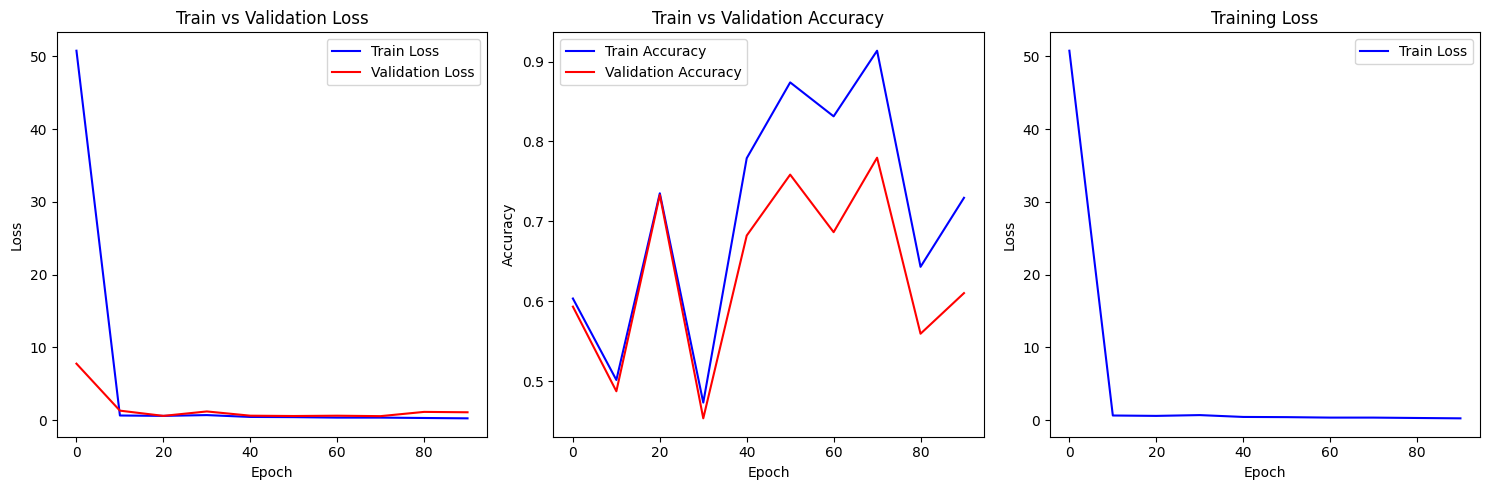


COMPREHENSIVE RESULTS COMPARISON

TOP 5 CONFIGURATIONS:
aggregation  hidden_dim  num_layers  dropout  accuracy     f1  precision  recall  parameters  training_time  inference_time_ms
        add         128           3      0.5    0.8008 0.7638     0.7451  0.7835       88962        17.1525             0.0532
       mean         256           2      0.2    0.7966 0.7576     0.7426  0.7732      177666        14.8617             0.0683
       mean          64           2      0.2    0.7839 0.7536     0.7091  0.8041       19842        18.6830             0.0394
       mean         128           2      0.5    0.7754 0.7535     0.6864  0.8351       56066        19.2130             0.0403
       mean          64           3      0.2    0.8051 0.7473     0.8000  0.7010       28098        20.4515             0.0455

PERFORMANCE BY AGGREGATION:
             accuracy      f1   parameters  training_time  inference_time_ms
aggregation                                                                

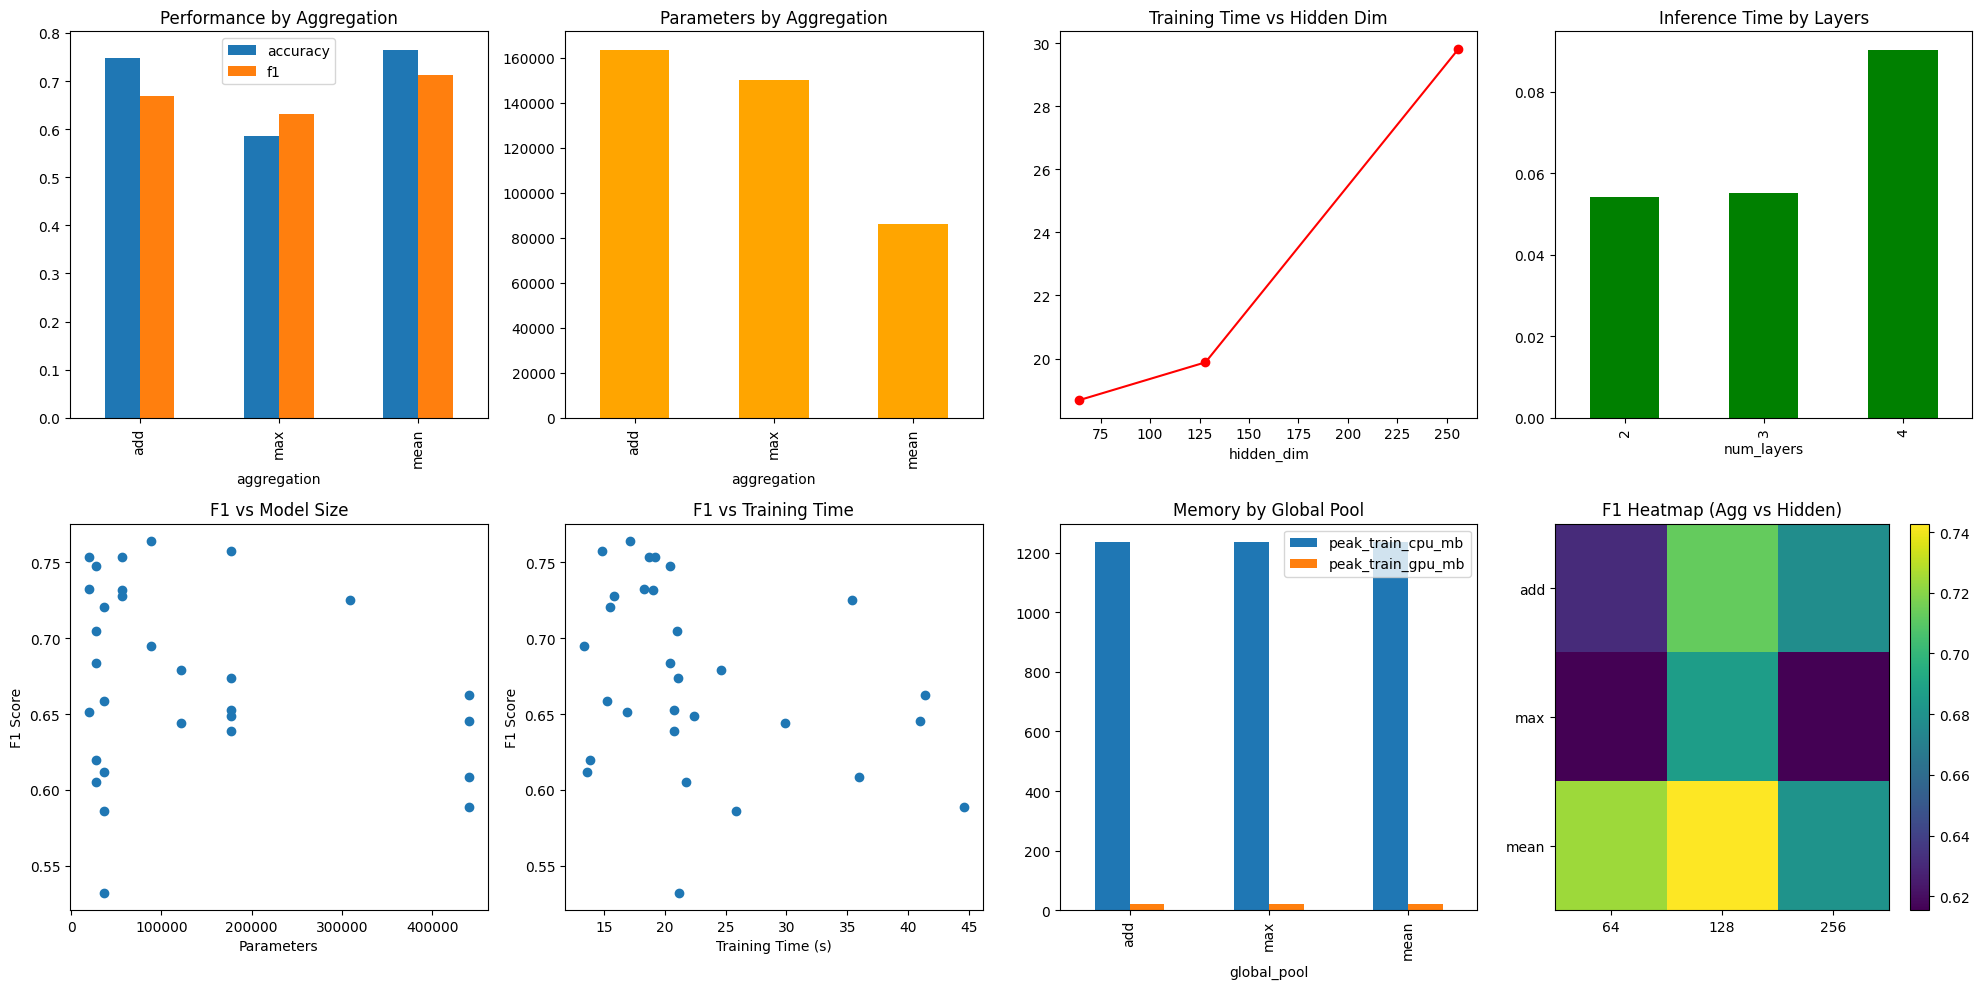


Saved: graphsage_results.csv, best_graphsage_model.pth, graphsage_analysis.png, training_curves.png


In [ ]:
results_df, best_model = run_graphsage_tuning(dataset, train_loader, val_loader, test_loader, device, n_trials=30)
